# 1. Environment Setup


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%pip install pandas numpy tqdm matplotlib seaborn scikit-learn scikeras tensorflow keras keras-tuner scipy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 5.2 MB/s eta 0:00:00


In [ ]:
# Data Manipulation
import pandas as pd
import re
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Deep Learning
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import tensorflow as tf
from tensorflow.keras.layers import Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, LeakyReLU
from keras.regularizers import l2
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, MaxPooling1D

## 1.1 Data Imports

In [ ]:
# Import Data
df = pd.read_csv('/content/drive/MyDrive/maastricht.csv')

# Separate features (X) and target variable (y)
X = df.drop('precipitation', axis=1)
y = df['precipitation']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape the data for LSTM (samples, timesteps, features)
X_train_reshaped = np.expand_dims(X_train, axis=1)  # Add timestep dimension
X_test_reshaped = np.expand_dims(X_test, axis=1)

# 2. Base Transformer

### High-Level Overview of the Transformer Model Structure and Workflow

This TensorFlow/Keras-based model uses a **Transformer Encoder architecture** for tasks like sequence modeling or regression. Below is a breakdown of its structure and functioning:

**Step 1: Inputs**
- The model expects input sequences with a shape of `(timesteps, features)`.
- These sequences are passed into the *Transformer Encoder Block*.

**Step 2: Transformer Encoder Block**
- Each block computes *self-attention* using multi-head attention.
- Processes input relationships, enhancing sequence understanding.
- Outputs enriched representations for downstream layers.

**Step 3: Pooling**
- The *GlobalAveragePooling1D* layer collapses the sequence dimension, retaining only the most informative features.

**Step 4: Fully Connected Layers**
- Non-linear layers refine the features into a form suitable for prediction.
- Dropout regularization prevents overfitting.

**Step 5: Output**
- A *single dense neuron* produces a regression output.

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization
from tensorflow.keras.layers import MultiHeadAttention, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Define the Transformer Encoder Block
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    # Multi-Head Self Attention
    attention = MultiHeadAttention(num_heads=num_heads, key_dim=head_size)(inputs, inputs)
    attention = Dropout(dropout)(attention)
    attention = LayerNormalization(epsilon=1e-6)(attention + inputs)

    # Feedforward Network
    ff = Dense(ff_dim, activation="relu")(attention)
    ff = Dropout(dropout)(ff)
    ff = Dense(inputs.shape[-1])(ff)
    ff = LayerNormalization(epsilon=1e-6)(ff + attention)
    return ff

# Input layer
input_shape = (X_train_reshaped.shape[1], X_train_reshaped.shape[2])  # (timesteps, features)
inputs = Input(shape=input_shape)

# Add Transformer Encoder Blocks
x = transformer_encoder(inputs, head_size=64, num_heads=4, ff_dim=128, dropout=0.2)
x = transformer_encoder(x, head_size=64, num_heads=4, ff_dim=128, dropout=0.2)

# Global Average Pooling
x = GlobalAveragePooling1D()(x)

# Fully Connected Layer
x = Dense(64, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(32, activation="relu")(x)
x = Dropout(0.2)(x)

# Output Layer
outputs = Dense(1)(x)

# Build and Compile the Model
model = Model(inputs, outputs)

# Compile the model
learning_rate = 0.00005  # Adjust as needed
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='mse')

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

# Train the model
history = model.fit(
    X_train_reshaped, y_train,
    epochs=100,  # Maximum number of epochs
    batch_size=32,
    validation_data=(X_test_reshaped, y_test),
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4638

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - loss: 0.4613 - val_loss: 0.2433
Epoch 2/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.2689 - val_loss: 0.1883
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2380 - val_loss: 0.1723
Epoch 4/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2607 - val_loss: 0.1658
Epoch 5/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1986 - val_loss: 0.1608
Epoch 6/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1948 - val_loss: 0.1566
Epoch 7/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2313 - val_loss: 0.1546
Epoch 8/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1786 - val_loss: 0.1512
Epoch 9/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1965 - val_loss: 0.1470
Epoch 10/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1879 - val_loss: 0.1445
Epoch 11/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1519 - val_loss: 0.1409
Epoch 12/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1624 - va

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


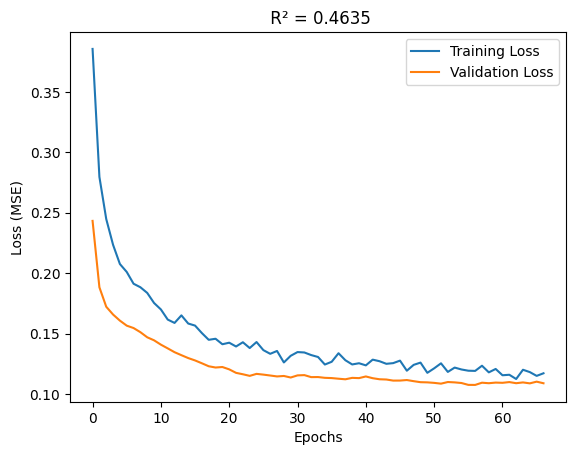

In [ ]:
plot_model_results(history, model, X_test_reshaped, y_test)

#5. Increase Complexity/Nuance

1. **Increased Dimensionality:**
   - Higher `head_size` (128) and `ff_dim` (256/512) allow the model to capture more complex relationships and encode richer feature representations.

2. **Deeper Architecture:**
   - Stacking 5 Transformer Encoder Blocks improves the model's ability to learn hierarchical and long-range dependencies in the data.

3. **Regularization Enhancements:**
   - Increased `dropout` (0.3) and added L2 regularization in fully connected layers reduce overfitting, promoting better generalization.

4. **Optimized Training Strategy:**
   - Lower learning rate (`0.00003`) ensures finer updates for the more complex architecture.
   - Additional `ReduceLROnPlateau` callback dynamically adjusts learning rate, improving convergence.

5. **Increased Fully Connected Depth:**
   - More layers (128 → 64 → 32 units) allow finer feature transformations, improving downstream task performance.

6. **Smaller Batch Size:**
   - Using a batch size of 16 enhances generalization for deeper models by introducing more stochasticity during training.


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization
from tensorflow.keras.layers import MultiHeadAttention, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Define the Transformer Encoder Block
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    # Multi-Head Self Attention
    attention = MultiHeadAttention(num_heads=num_heads, key_dim=head_size)(inputs, inputs)
    attention = Dropout(dropout)(attention)
    attention = LayerNormalization(epsilon=1e-6)(attention + inputs)

    # Feedforward Network
    ff = Dense(ff_dim, activation="relu")(attention)
    ff = Dropout(dropout)(ff)
    ff = Dense(inputs.shape[-1])(ff)
    ff = LayerNormalization(epsilon=1e-6)(ff + attention)
    return ff

# Input layer
input_shape = (X_train_reshaped.shape[1], X_train_reshaped.shape[2])  # (timesteps, features)
inputs = Input(shape=input_shape)

# Add multiple Transformer Encoder Blocks with higher dimensions
x = transformer_encoder(inputs, head_size=128, num_heads=8, ff_dim=256, dropout=0.3)
x = transformer_encoder(x, head_size=128, num_heads=8, ff_dim=256, dropout=0.3)
x = transformer_encoder(x, head_size=128, num_heads=8, ff_dim=256, dropout=0.3)

# Optional: Stack more encoder layers if needed
x = transformer_encoder(x, head_size=128, num_heads=8, ff_dim=512, dropout=0.3)
x = transformer_encoder(x, head_size=128, num_heads=8, ff_dim=512, dropout=0.3)

# Global Average Pooling
x = GlobalAveragePooling1D()(x)

# Fully Connected Layers with increased depth
x = Dense(128, activation="relu", kernel_regularizer="l2")(x)
x = Dropout(0.3)(x)
x = Dense(64, activation="relu", kernel_regularizer="l2")(x)
x = Dropout(0.3)(x)
x = Dense(32, activation="relu", kernel_regularizer="l2")(x)
x = Dropout(0.3)(x)

# Output Layer
outputs = Dense(1)(x)

# Build and Compile the Model
model = Model(inputs, outputs)

# Compile the model
learning_rate = 0.00003  # Adjusted learning rate for more complex model
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='mse')

# Callbacksf
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

# Train the model
history = model.fit(
    X_train_reshaped, y_train,
    epochs=150,  # Increase max epochs to accommodate deeper architecture
    batch_size=16,  # Decrease batch size for better generalization
    validation_data=(X_test_reshaped, y_test),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


Epoch 1/150


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 8, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.7690

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 8, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


183/183 ━━━━━━━━━━━━━━━━━━━━ 49s 34ms/step - loss: 1.7687 - val_loss: 1.5984 - learning_rate: 3.0000e-05
Epoch 2/150
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 1.6312 - val_loss: 1.5547 - learning_rate: 3.0000e-05
Epoch 3/150
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 1.5979 - val_loss: 1.5077 - learning_rate: 3.0000e-05
Epoch 4/150
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 1.5622 - val_loss: 1.4628 - learning_rate: 3.0000e-05
Epoch 5/150
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - loss: 1.4561 - val_loss: 1.4187 - learning_rate: 3.0000e-05
Epoch 6/150
183/183 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - loss: 1.4276 - val_loss: 1.3794 - learning_rate: 3.0000e-05
Epoch 7/150
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - loss: 1.3941 - val_loss: 1.3348 - learning_rate: 3.0000e-05
Epoch 8/150
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - loss: 1.3357 - val_loss: 1.2936 - learning_rate: 3.0000e-05
Epoch 9/150
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 1.2935 - val_loss:

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 8, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step


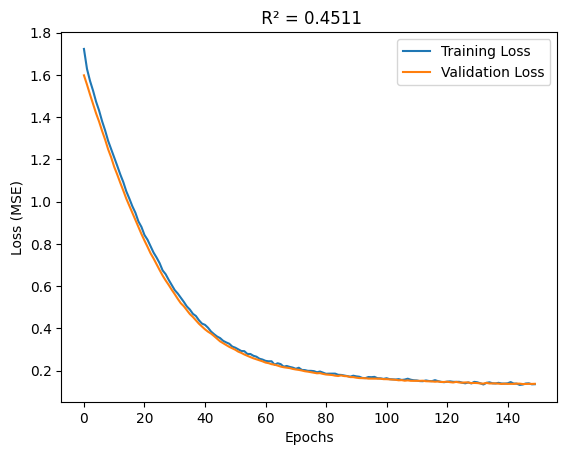

In [ ]:
plot_model_results(history, model, X_test_reshaped, y_test)